In [42]:
from models import *
from utils.utils import *
from utils.datasets import *
from utils.kittiloader import *
from itertools import compress



import os
import sys
import time
import datetime
import argparse
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
import time

from mpl_toolkits.mplot3d import Axes3D


def drawBEV(point_cloud_,color=(0,1,0)):
    ''' Draw a bird eye view using matplotlib
    
    
    '''
    f = plt.figure(figsize=(18, 14))
    ax = f.add_subplot(111)
    ax.scatter(point_cloud_[:,1],point_cloud_[:,0],
                s=0.1, c=[color]*len(point_cloud_))
    ax.set_title('BEV before frustum extraction')
    ax.set_ylim(0,15)
    ax.set_xlim(-10,10)
    ax.set_facecolor((0,0,0))
# #     plt.show()
    
def draw3D(point_cloud_,color=(0,1,0),angle=(60,180)):
    f = plt.figure(figsize=(15, 10))
    ax = f.add_subplot(111, projection='3d')
    ax.set_facecolor((0, 0, 0))
    ax.set_xlim3d(-10,20)
    ax.set_ylim3d(-10,10)
    ax.set_zlim3d(-3,5)
    ax.view_init(angle[0],angle[1])
    ax.grid(False)
    plt.axis('off')
    ax.scatter(point_cloud_[:,0],point_cloud_[:,1],point_cloud_[:,2], s=0.1, c=[(0,1,0)]*len(point_cloud_))
#     plt.show()

axes_limits = [
    [0, 10], # X axis range
    [-10, 10], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']


image_folder = 'examples/'
config_path = 'config/v390.cfg'
weights_path = 'weights/v390_final.weights'
kitti_path = '/home/project/ZijieMA/KITTI/'
class_path = 'data/coco.names'
conf_thres = 0.5
nms_thres = 0.4
batch_size = 1
n_cpu = 16
img_size = 416
use_cuda = True
CUDA_available = torch.cuda.is_available() and use_cuda

detections = torch.tensor([
    [  5.0433, 208.0689, 133.5634, 274.0513,   0.9992,   0.9995,   2.0000],
         [202.3678, 203.0705, 242.1279, 233.4327,   0.9980,   0.9999,   2.0000]
#          [118.8502, 203.6419, 208.2199, 263.8680,   0.9891,   0.9758,   2.0000]
])
if detections[0] is not None:
        detections_with_distance = torch.zeros((detections.shape[0],detections.shape[1]+1))
        detections_with_distance[:,:-1] = detections
        
img_id = 8
img_path = 'examples/000008.png'
img_size_after_resize = img_size
lidar_path = '%straining/velodyne/%06d.bin' % (kitti_path, img_id)
calib = calibread('%straining/calib/%06d.txt' % (kitti_path, img_id))
img = cv2.imread('/home/project/ZijieMA/PyTorch-YOLOv3/examples/%06d.png' % img_id, cv2.IMREAD_UNCHANGED)
# img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img_width_orig = img.shape[1]

img_height_orig = img.shape[0]

pad_x = max(img_height_orig - img_width_orig, 0) * (img_size_after_resize / max(img_width_orig, img_height_orig))
pad_y = max(img_width_orig - img_height_orig, 0) * (img_size_after_resize / max(img_width_orig, img_height_orig))
point_cloud = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)

# Image height and width after padding is removed
unpad_h = img_size_after_resize - pad_y
unpad_w = img_size_after_resize - pad_x
# detections with shape: (x1, y1, x2, y2, object_conf, class_score, class_pred)

P2 = calib["P2"] # 3x4 matris projection matrix after rectification
# （u,v,1） = dot(P2, (x,y,z,1))
Height_of_camera = 1.65
fu = P2[0][0]  # for horizontal position
fv = P2[1][1]  


In [43]:
for detection in detections_with_distance:
    detection = detection.numpy()
    point_cloud = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)

    # detections with shape: (x1, y1, x2, y2, object_conf, class_score, class_pred)
    box_h = ((detection[3] - detection[1]) / unpad_h) * img_height_orig
    box_w = ((detection[2] - detection[0]) / unpad_w) * img_width_orig
    v_upper = ((detection[1] - pad_y // 2) / unpad_h) * img_height_orig
    u_left = ((detection[0] - pad_x // 2) / unpad_w) * img_width_orig
    v_bottom = v_upper + box_h
    u_right = u_left + box_w
    D_rough = Height_of_camera * fv / (v_bottom - img_height_orig/2)
    if D_rough > 0:
        # remove points that are located behind the camera:
        point_cloud = point_cloud[point_cloud[:, 0] > (D_rough - 3), :]
        # remove points that are located too far away from the camera:
        point_cloud = point_cloud[point_cloud[:, 0] < min(80, D_rough + 3), :]
        point_cloud = point_cloud[point_cloud[:,2] > -1.5,:]
        point_cloud = point_cloud[point_cloud[:,2] < -1,:]
        
        ########################################################################
        # point_cloud               n x 4   original xyzr value before cali in velo coordinate
        # point_cloud_xyz           n x 3   xyz value before cali in velo coordinate
        # point_cloud_xyz_hom       n x 4   xyz1 in velo coordinate
        # point_cloud_xyz_camera    n x 4   xyz1 in camera coordinate
        # point_cloud_camera        n x 4   xyzr in camera coordinate
        # img_points_hom            n x 3   uv_
        # img_points                n x 2   UV
        ########################################################################
        
        R0_rect = np.eye(4)
        R0_rect[0:3, 0:3] = calib["R0_rect"] # 3x3 -> 4x4 up left corner
        Tr_velo_to_cam = np.eye(4)
        Tr_velo_to_cam[0:3, :] = calib["Tr_velo_to_cam"] # 3x4 -> 4x4 up left corner

        # point_cloud_xyz = point_cloud[:, 0:3] # num_point x 3 (x,y,z,reflectance) reflectance don't need
        point_cloud_xyz_hom = np.ones((point_cloud.shape[0], 4))
        point_cloud_xyz_hom[:, 0:3] = point_cloud[:, 0:3] # (point_cloud_xyz_hom has shape (num_points, 4))
        # the 4th column are all 1

        # project the points onto the image plane (homogeneous coords):
        # (U,V,_) = P2 * R0_rect * Tr_velo_to_cam * point_cloud_xyz_hom
        # normalize: (U,V,1)
        img_points_hom = np.dot(P2, np.dot(R0_rect, np.dot(Tr_velo_to_cam, point_cloud_xyz_hom.T))).T # (point_cloud_xyz_hom.T has shape (4, num_points))
        img_points = np.zeros((img_points_hom.shape[0], 2))
        img_points[:, 0] = img_points_hom[:, 0]/img_points_hom[:, 2]
        img_points[:, 1] = img_points_hom[:, 1]/img_points_hom[:, 2]

        row_mask = np.logical_and(
                        np.logical_and(img_points[:, 0] >= u_left,
                                       img_points[:, 0] <= u_right),
                        np.logical_and(img_points[:, 1] >= v_upper,
                                       img_points[:, 1] <= v_bottom))

In [44]:
point_cloud_mask = point_cloud[row_mask,:]

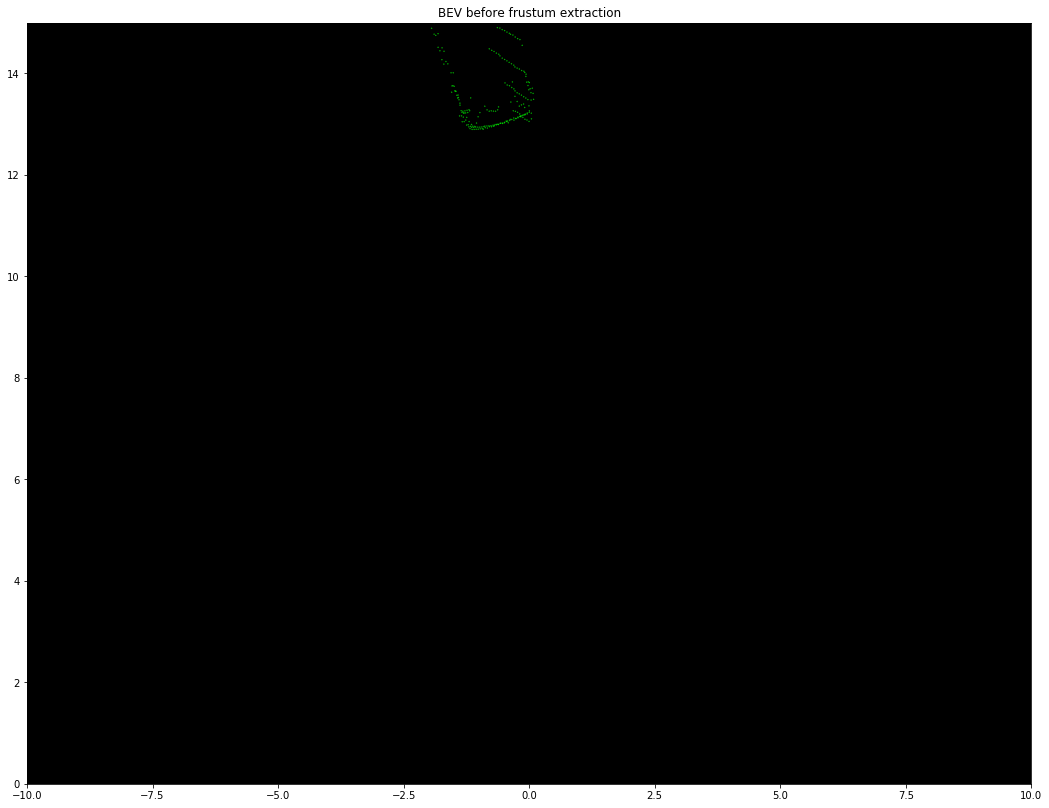

In [45]:
# def ransac_with_bbox(point_cloud_with_mask,)
# len(point_cloud_mask)
drawBEV(point_cloud_mask)
plt.show()

In [48]:
def findIntersection(x1, y1, x2, y2, x3, y3, x4, y4):
    '''generate intersection point using 4 different point'''
    px = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / (
                (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
    py = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / (
                (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4))
    return px, py

def findEdgePoint(x1, y1, x2, y2, x3, y3, x4, y4):
    '''
    checking point that are on the far side
    '''
    df = [[x1,y1,0],[x2,y2,0],[x3,y3,0],[x4,y4,0]]
    for point in df:
        point[2]=point[0]**2+point[1]**2
    df = sorted(df,key=lambda x: x[2])
    # point start always from left side
    if df[0][1] <= df[1][1]:
        return df[0][0], df[0][1], df[1][0], df[1][1]
    else:
        return df[1][0], df[1][1], df[0][0], df[1][1]
    
def ransac_with_bbox(point_cloud_with_mask, category,rough_D):
    '''

    :param point_cloud_with_mask: point cloud in frustum area
    :param n_sample: sample to start ransac(should be less than len(point_cloud_with_mask))
    :param category: decide how we deal with the regresion
    '''
    # category numbers are according to the datasets. Here with COCO
    # car, bus and truck
    if category in [2,5,7]:
        '''
        idea with the car is to use ransac to filter out outliers and regression with one line that describes a
        edge. The outliers then run another ransac to generate another edge
        '''
        ransac = linear_model.RANSACRegressor(max_trials=1000, stop_probability=0.999)
        ransac.fit(point_cloud_with_mask[:, 1].reshape(-1, 1), point_cloud_with_mask[:, 0].reshape(-1, 1))

        # line points for first ransac
        inlier_index = list(compress(range(len(ransac.inlier_mask_)), ransac.inlier_mask_))
        left_y_1 = point_cloud_with_mask[inlier_index, 1].min()
        right_y_1 =  point_cloud_with_mask[inlier_index, 1].max()
        left_x_1 = ransac.predict([[left_y_1, ]])[0][0]
        right_x_1 = ransac.predict([[right_y_1, ]])[0][0]
        print(left_x_1,left_y_1,right_x_1,right_y_1)
        
        drawBEV(point_cloud_mask[inlier_index,:])
        plt.show()
        outlier_index = list(compress(range(len(ransac.inlier_mask_)), [not i for i in ransac.inlier_mask_]))
        outlier_point_cloud = point_cloud_with_mask[outlier_index,:]
        if len(outlier_index)>1/5*(len(point_cloud_with_mask)):

            ransac.fit(outlier_point_cloud[:, 1].reshape(-1, 1),
                       outlier_point_cloud[:, 0].reshape(-1, 1))

            inlier_index = list(compress(range(len(ransac.inlier_mask_)), ransac.inlier_mask_))
            left_y_2 = outlier_point_cloud[inlier_index, 1].min()
            right_y_2 =  outlier_point_cloud[inlier_index, 1].max()
            left_x_2 = ransac.predict([[left_y_2, ]])[0][0]
            right_x_2 = ransac.predict([[right_y_2, ]])[0][0]
            print([left_y_1, left_y_2, right_y_1, right_y_2],[left_x_1, left_x_2, right_x_1, right_x_2])
            x_2, y_2 = findIntersection(left_x_1,left_y_1,right_x_1,right_y_1,left_x_2,left_y_2,right_x_1,right_y_2)
            x_1, y_1, x_3, y_3 = findEdgePoint(left_x_1,left_y_1,right_x_1,right_y_1,left_x_2,left_y_2,right_x_2,right_y_2)
            # return coordination of 3 contour point, from left to right.
            if D_rough-3 <x_2< D_rough +3 and point_cloud_mask[:,1].min()<y_2<point_cloud_mask[:,1].max():
                return [x_1, y_1, x_2, y_2, x_3, y_3]
            else: [left_x_1, left_y_1, right_x_1, right_y_1]
        else: return [left_x_1, left_y_1, right_x_1, right_y_1]

    # person
    elif category == 0:
        '''the idea of the human can use the center cluster to be the distance'''
        return None
    else:
        return None

13.10221 -1.44 13.206098 0.088


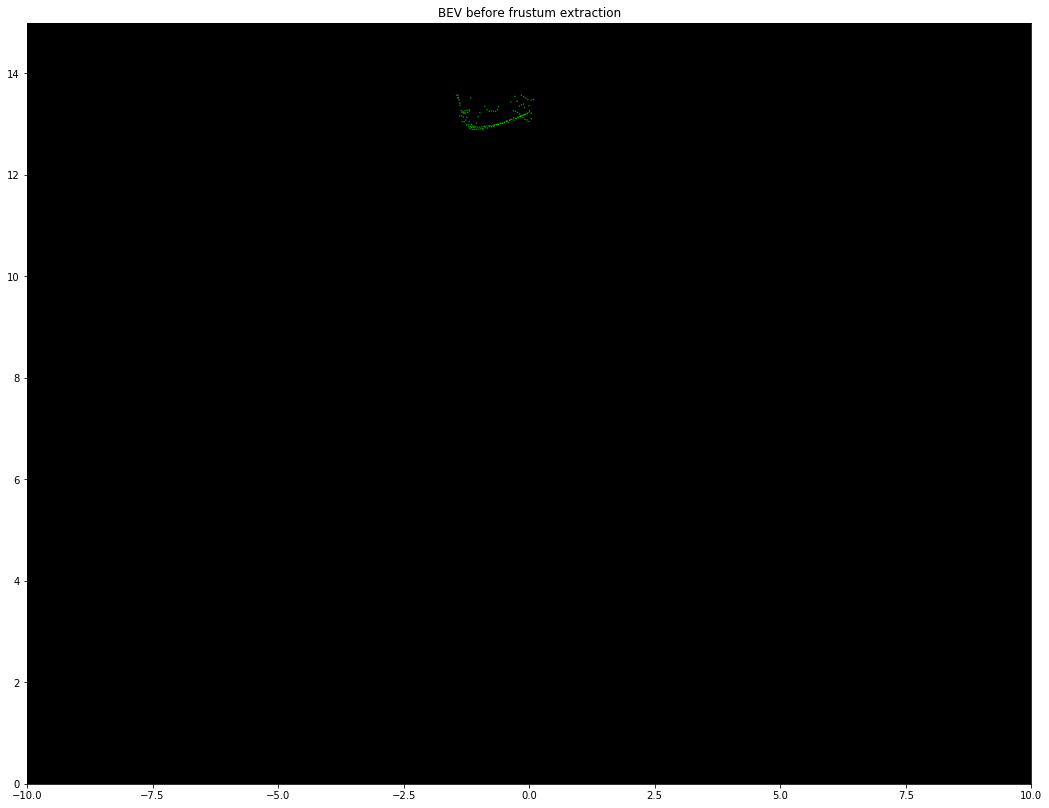

[-1.44, -2.248, 0.088, 0.079] [13.10221, 15.636628, 13.206098, 13.774422]


[13.10221, -1.44, 13.205523, 0.079550706, 13.206098, 0.088]

In [49]:
a = ransac_with_bbox(point_cloud_mask,detection[6],D_rough)
a

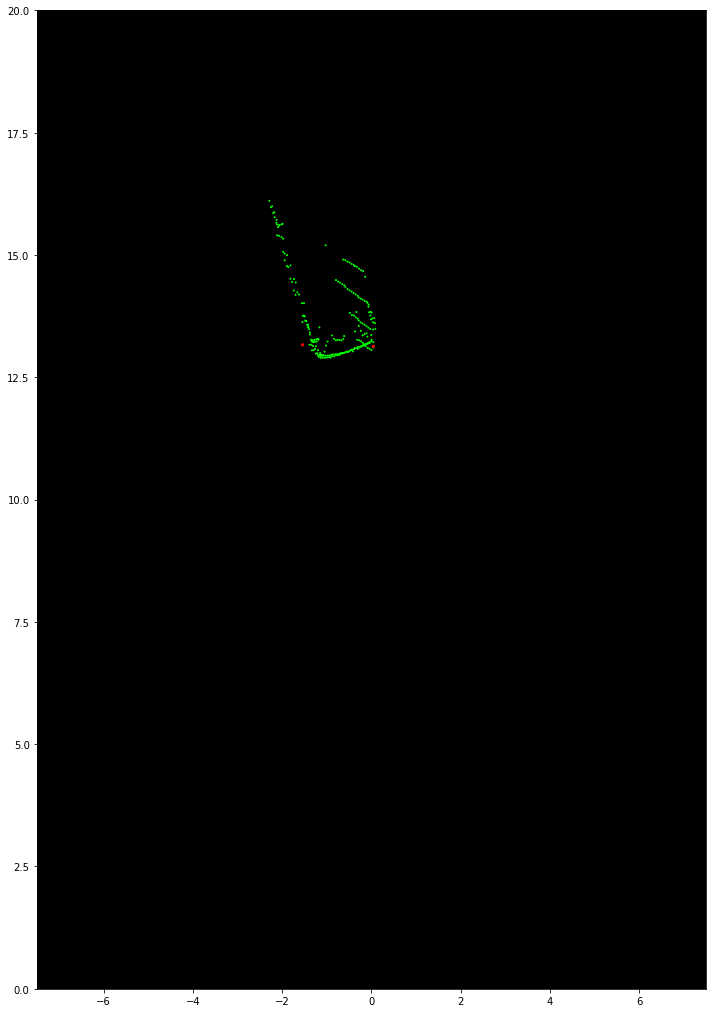

In [40]:
f4 = plt.figure(figsize=(12, 18))
ax4 = f4.add_subplot(111)
ax4.scatter(point_cloud_mask[:,1],point_cloud_mask[:,0],
            s=1, c=[(0,1,0)]*len(point_cloud_mask))
ax4.scatter([-1.544, 0.046],[13.162425, 13.131883],s = 5, c=[(1,0,0)]*4)
# ax4.plot([a[1],a[3],a[5]],[a[0],a[2],a[4]],'k-', color = 'r')
ax4.set_ylim(0,20)
ax4.set_xlim(-7.5,7.5)
ax4.set_facecolor((0,0,0))
plt.show()

In [50]:
3>2>1

True